# TP1: Análisis Básico

Doce atletas entrenan para una competencia de 100m llanos. El entrenamiento se realiza aún en condiciones climáticas adversas. El archivo `tiempos.txt` contiene los tiempos en segundos de cada atleta para un entrenamiento en un día soleado, en un día nublado y en un día de lluvia intensa.

Utilizando el lenguaje Python, procedimos a analizar los datos. Como primer paso, importamos los paquetes a utilizar.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 1. Datos <a id='datos'></a>

Cargamos los datos y los visualizamos.

In [4]:
# Atleta tiempo_sol tiempo_nublado tiempo_lluvia
datos = np.loadtxt('tiempos.txt', skiprows=1)

In [5]:
pd.DataFrame(datos[:,1:], columns=['sol', 'nublado', 'lluvia'], index=datos[:,0]).T

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
sol,11.1,13.0,16.1,14.5,12.0,11.0,15.1,14.4,16.1,17.0,12.2,14.4
nublado,11.3,12.8,16.0,14.1,12.5,11.6,14.6,14.2,16.1,16.7,12.4,14.1
lluvia,19.4,18.2,19.0,18.9,19.1,18.7,189.0,19.9,18.5,19.2,18.8,19.2


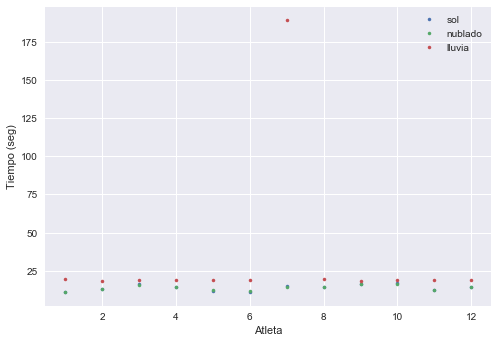

In [ ]:
plt.plot(datos[:,0], datos[:,1], '.', label='sol')
plt.plot(datos[:,0], datos[:,2], '.', label='nublado')
plt.plot(datos[:,0], datos[:,3], '.', label='lluvia')
plt.xlabel('Atleta')
plt.ylabel('Tiempo (seg)')
plt.legend()
plt.show()

En lluvia tenemos un outlier. Vemos que parecería ser porque faltó el punto decimal. Lo agregamos.

In [8]:
datos[6, 3] = datos[6, 3] / 10.

In [9]:
sol, nublado, lluvia = datos[:,1], datos[:, 2], datos[:, 3]

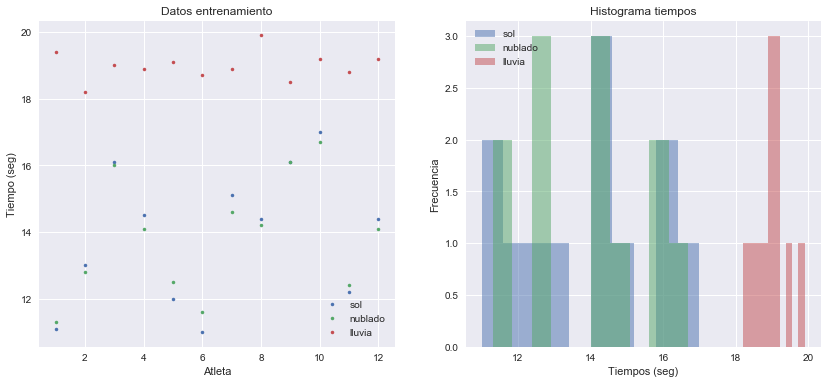

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(axs[0])
plt.plot(datos[:,0], datos[:,1], '.', label='sol')
plt.plot(datos[:,0], datos[:,2], '.', label='nublado')
plt.plot(datos[:,0], datos[:,3], '.', label='lluvia')
plt.xlabel('Atleta')
plt.ylabel('Tiempo (seg)')
plt.title('Datos entrenamiento')
plt.legend()

plt.sca(axs[1])
plt.hist(sol, alpha=0.5, label='sol')
plt.hist(nublado, alpha=0.5, label='nublado')
plt.hist(lluvia, alpha=0.5, label='lluvia')
plt.title('Histograma tiempos')
plt.xlabel('Tiempos (seg)')
plt.ylabel('Frecuencia')
plt.legend()

En una primera inspección se observa que los datos correspondientes a los días soleados y nublados se comportan de manera similar. No parecería que el tiempo de los atletas en días nublados sea más lento que en soleados. Si se ve que en días de lluviosos los tiempos son más largos. También se ve que en días de lluvia hay menos varianza en el tiempo de los atletas.

## 2. Tests

Aplicamos distintos test sobre los datos para evaluar diferentes hipótesis sobre los datos.

### 2.1. Los atletas son más lentos en días de lluvia que en días soleados.

Este enunciado puede analizarse desde varias perspectivas. Un caso sería analizar si los tiempos en día de lluvia son en promedio mayor que en los días soleados.

Con esta idea podemos plantear como hipótesis nula que los tiempos de ambos conjuntos de datos (sol, lluvia) tienen el mismo promedio. Podemos evaluar esta hipótesis mediante un t-test de dos muestras. En particular, como los datos están apareados por cada atleta podemos aprovechar para hacer el t-test de muestras apareadas, que es más robusto.

### Hipótesis del t-test

Consideramos entonces dos variables: 

* $\mathcal{X}_{sol}$: muestra de tiempos de los atletas en días soleados 
* $\mathcal{X}_{lluvia}$: muestra de tiempos de los atletas en días de lluvia 

Para poder aplicar el t-test para estas dos distribuciones tenemos las siguientes hipótesis:

1. $\mathcal{X}_{sol}$ y $\mathcal{X}_{lluvia}$ se distribuyen de forma normal. 
2. Las muestras de $\mathcal{X}_{sol}$ y $\mathcal{X}_{lluvia}$ son independientes cada una. 
3. Ambas distribuciones tienen igual varianza.
4. Ambas muestras tienen la misma cantidad de datos.
5. Para un test de muestras apareadas, es ideal observar si la diferencia en los valores apareados se distribuye normalmente.

Verificamos las hipótesis.

#### Hipótesis 1

Hacemos un KS test para ver si las muestras provienen de una distribución normal. Como el test evalúa las muestras contra una normal standard, es necesario estandarizar las muestras.

In [ ]:
t_sol, p_sol = sp.stats.kstest((sol - sol.mean())/sol.std(), 'norm')
t_lluvia, p_lluvia = sp.stats.kstest((lluvia - lluvia.mean())/lluvia.std(), 'norm')
pd.DataFrame({'sol':{'t': t_sol, 'p': p_sol}, 'lluvia': {'t': t_lluvia, 'p': p_lluvia}})

,lluvia,sol
p,0.980328,0.814452
t,0.135442,0.183383


En ambas distribuciones, el p-valor del test no llega a la significancia (> 0.05). Si miramos el histograma en la sección **[Datos](#datos)**, los tiempos en sol no parecerían ser normales. En cambio, los de lluvia podrían serlo. Sería necesario tener más muestras para cada caso. A pesar de esto, seguimos adelante con el uso del test.

#### Hipótesis 2

Esto es válido por la característica de las mediciones, donde cada atleta corre independientemente de los otros.

#### Hipótesis 3

Para evaluar igualdad de varianza utilizamos el test de [Levene](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html), ya que se lo recomienda cuando no hay seguridad de normalidad de las distribuciones.

In [ ]:
var_t, var_p = sp.stats.levene(sol, lluvia)
print('t = {:.4f}, p = {:.4f}'.format(var_t, var_p))

t = 13.0840, p = 0.0015


Por el resultado del p-valor, debemos descartar la hipótesis nula y asumir que ambas muestras tienen distinta varianza.

#### Hipótesis 4

Se cumple por los datos.

#### Hipótesis 5

Evaluamos normalidad de las distancias a pares con un kstest.

In [ ]:
d = lluvia - sol
print(sp.stats.kstest((d-d.mean())/d.std(), 'norm'))

KstestResult(statistic=0.11611504165177383, pvalue=0.99695893157033921)


Mediante el resultado del test no podemos descartar que la distancia entre valores sea normal.

Habiendo hecho el análisis de las hipótesis, evaluamos la hipótesis nula de igual varianza para ambas distribuciones utilizando un t-test de dos muestras apareadas.

#### Evaluación

Realizamos el test de muestras apareadas pero dado que tuvimos que descartar la hipótesis de que ambas muestras tienen igual media, realizamos también un test de Welsh (que no requiere esta hipótesis).

In [ ]:
mean_rel = sp.stats.ttest_rel(lluvia, sol)
mean_welsh = sp.stats.ttest_ind(lluvia, sol, equal_var=False)
pd.DataFrame([mean_rel, mean_welsh], index=['Rel', 'Welsh'])

,statistic,pvalue
Rel,8.576228,0.000003
Welsh,8.482840,0.000002


En ambos casos el p-valor es muy bajo, lo cual nos permite descartar la hipótesis nula donde ambas distribuciones tienen igual media.

En particular, dado que en ambos casos el estadístico representa la diferencia entre los días de lluvia y los días de sol y el estadístico es positivo, podemos concluir que en días de lluvia los atletas son más lentos.



Para fortalecer la conclusión alcanzada realizamos un test de permutaciones para el estadístico $\bar{\mathcal{X}}_{lluvia}$ - $\bar{\mathcal{X}}_{sol}$. Esto es, queremos rechazar la hipótesis nula donde los tiempos observados para lluvia y sol son indistintos del clima. Si ese fuera el caso, generando muestras con las etiquetas del clima cambiadas, veríamos que el estadístico original se acomoda bien a la distribución creada.

### Test de permutaciones

In [ ]:
todos =  np.concatenate((sol, lluvia))
etiquetas_sol = np.repeat('sol', sol.size)
etiquetas_lluvia = np.repeat('lluvia', lluvia.size)
etiquetas = np.concatenate((etiquetas_sol, etiquetas_lluvia))

In [ ]:
print('Todos los valores con respectivas etiquetas.')
pd.DataFrame({'valores': todos, 'etiquetas':etiquetas}).T

Todos los valores con respectivas etiquetas.


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
etiquetas,sol,sol,sol,sol,sol,sol,sol,sol,sol,sol,...,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia
valores,11.1,13,16.1,14.5,12,11,15.1,14.4,16.1,17,...,19,18.9,19.1,18.7,18.9,19.9,18.5,19.2,18.8,19.2


In [ ]:
delta_0 = lluvia.mean() - sol.mean()
print('Diferencia de promedios entre lluvia y sol: {:.4f} seg'.format(delta_0))

Diferencia de promedios entre lluvia y sol: 5.0750 seg


Calculamos distribución con permutaciones.

In [ ]:
deltas = []
for i in range(1000):
    etiquetas_s = np.copy(etiquetas)
    np.random.shuffle(etiquetas)
    sol_s = todos[etiquetas_s == 'sol']
    lluvia_s = todos[etiquetas_s == 'lluvia']
    delta_1 = lluvia_s.mean() - sol_s.mean()
    deltas.append(delta_1)

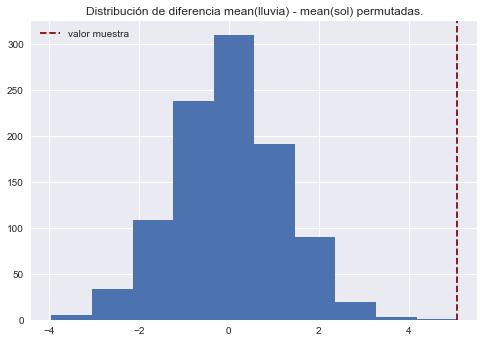

In [ ]:
plt.hist(deltas)
plt.axvline(delta_0, color='darkred', linestyle='--', label='valor muestra')
plt.title(u'Distribución de diferencia mean(lluvia) - mean(sol) permutadas.')
plt.legend()

In [ ]:
deltas = np.array(deltas)

In [ ]:
p = np.sum(deltas > delta_0) / 1000.
print('Probabilidad de el valor de la muestra en la distribución de permutaciones: {:.4f}'.format(p))

Probabilidad de el valor de la muestra en la distribución de permutaciones: 0.0000


La probabilidad calculada arriba es $P(\bar{\mathcal{X}}^p_{lluvia} - \bar{\mathcal{X}}^p_{sol} > \bar{\mathcal{X}}_{lluvia} - \bar{\mathcal{X}}_{sol})$.
Siendo $\bar{X}^p$ la distribución de promedios de tiempo de lluvia o sol habiendo permutado los valores con las etiquetas.

Viendo que es muy poco probable que la forma en que se dieron las etiquetas para los tiempos en sol y lluvia se haya originado de una distribución donde las etiquetas son independientes de los tiempos, descartamos la hipótesis nula. En particular, evaluamos la probabilidad de un resultado aún más extremo que el original. Esto es, que las diferencias de tiempos en promedio en días de lluvia comparados con los promedios en sol sea mayor que la observada. Esto indica que un resultado tan o más extremo que el encontrado es muy poco probable.

_Conclusiones: Habiendo visto dos resultados que descartan la hipótesis nula $h_0$ ambas muestras tienen igual media, podemos considerar que este no es el caso. Además, dada la evaluación en el test de permutaciones y el estadístico obtenido en el t-test apareado, concluímos que el promedio de tiempos en días de lluvia es mayor que en días soleados._

### 2.2. El cielo nublado no influye en los tiempos de los atletas.
#### Hago dos tests de muestras apareadas que relacionen el clima nublado con los dos restantes

Para poder llevar adelante los dos tests de muestras apareadas requeridos, resta verificar las hipótesis enumeradas en la sección anterior para la categoría "nublado". Sin embargo, como fue mencionado anteriormente, se observa un comportamiento similar entre los datos correspondientes a los días soleados y nublados en los gráficos "datos entrenamiento" e "histograma tiempos" lo que nos conduce a estudiar explícitamente si ambos sets de datos tienen igual distribución. En caso afirmativo, se podrían aplicar los tests ya que las hipótesis ya fueron verificadas para los datos de los días soleados.

Para evaluar la similitud entre las distribuciones, utilizamos la [Divergencia Kullback-Leibler](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). Este cálculo mide con un valor en el rango 0, 1 la divergencia de una distribución respecto de otra. La medida no es simétrica, por lo que es necesario evaluarla en ambos sentidos. Esta se encuentra implementada en [scipy.stats.entropy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) al usarla con dos parámetros.

In [21]:
print("Divergencia KL sol vs. nublado: {:.4f}".format(sp.stats.entropy(sol, nublado)))
print("Divergencia KL nublado vs. sol: {:.4f}".format(sp.stats.entropy(nublado, sol)))

Divergencia KL sol vs. nublado: 0.0003
Divergencia KL nublado vs. sol: 0.0003


Los valores en ambos casos son cercanos a 0. Esto representa que no hay divergencia enrte las distribuciones. Podemos considerar que ambas distribuciones se comportan de forma equivalente. De esta manera pasamos a aplicar los tests que siguen.

Evaluamos la siguiente hipótesis nula:

$h_0^{sol}$ = los días nublados influyen de la misma manera que los días soleados en el tiempo de los atletas

In [49]:
t_sol, p_sol = sp.stats.ttest_rel(nublado, sol)
print('t_sol = {:.6f}, p_sol = {:.6f}'.format(t_sol, p_sol))

t_sol = -0.412138, p_sol = 0.688156


Debido a que se encontró un p-value de 0.688, no se puede descartar la hipótesis $h_0^{sol}$ sugerida. El resultado del estadístico indicaría que en los días nublados, los atletas logran tiempos menores.

$h_0^{lluvia}$ = los días nublados influyen de la misma manera que los días lluviosos en el tiempo de los atletas

In [ ]:
t_lluvia, p_lluvia = sp.stats.ttest_rel(nublado, lluvia)
print('t_lluvia = {:.6f}, p_lluvia = {:.6f}'.format(t_lluvia, p_lluvia))

t_lluvia = -9.720129, p_lluvia = 0.000001


En este caso, dado el bajo valor del p-value, descartamos la hipótesis nula. Esto significa que los tiempos en días nublados no son iguales a los tiempos en días de lluvia.

Comparando los resultados de ambos tests de muestras apareadas, se observa una clara diferencia entre la performance de los atletas entre los días nublados y de lluvia. Sin embargo, no puede decirse lo mismo respecto a los días soleados y nublados. Además, en ambos tests se obtiene que los atletas logran menores tiempos en los dias nublados, sin embargo la diferencia en menor en el par nublado-sol que nublado-lluvia.

En principio tenemos una primera contraposición al enunciado de que el clima nublado no afecta el tiempo de los atletas ya que los atletas logran tiempos mucho menores en clima nublados contra un clima lluvioso.

Para llegar a conclusiones más acabadas a continuación se realizan tests ANOVAs.

#### Test ANOVA para las tres muestras

Se quiere aplicar un test que permita comparar los tres climas juntos, para ver si entre ellos hay alguna diferencia. Teniendo en cuenta que las hipótesis que se asumen en un test ANOVA son análogas a las del t-test, se aplica también el test de Kruskal-Wallis (KW) el cual no asume la normalidad de los datos pero sí que todas las muestras pertenecen a una misma distribución.

In [ ]:
t_ANOVA, p_ANOVA = sp.stats.f_oneway(nublado, lluvia, sol)
't_ANOVA = {:.2f}, p_ANOVA = {}'.format(t_ANOVA, p_ANOVA)

't = 41.57, p = 9.6112634512e-10'

In [ ]:
t_KW, p_KW = sp.stats.kruskal(nublado, lluvia, sol)
't_KW = {:.2f}, p_KW = {}'.format(t_KW, p_KW)

't_KW = 23.39, p_KW = 8.33978539491e-06'

Este resultado indica que una de las tres muestras difiere del resto. Para poder identificarla entonces se repite el test pero esta vez de a pares.
#### Tests ANOVAs de a pares - Tests KW de a pares

Test ANOVA nublado-sol: ambos climas influyen de la misma manera sobre los atletas.

In [ ]:
t_1, p_1 = sp.stats.f_oneway(nublado, sol)
't_1 = {:.4f}, p_1 = {}'.format(t_1, p_1)

't_1 = 0.0029, p_1 = 0.957892655613'

Test KW nublado-sol: ambos climas influyen de la misma manera sobre los atletas.

In [ ]:
t_1KW, p_1KW = sp.stats.kruskal(nublado, sol)
't_1KW = {:.2f}, p_1KW = {}'.format(t_1KW, p_1KW)

't_1KW = 0.03, p_1KW = 0.862312311313'

ANOVA nublado-lluvia: ambos climas influyen de la misma manera sobre los atletas.

In [ ]:
t_2, p_2 = sp.stats.f_oneway(nublado, lluvia)
't_2 = {:.2f}, p_2 = {}'.format(t_2, p_2)

't_2 = 92.64, p_2 = 2.40875774137e-09'

Test KW nublado-lluvia: ambos climas influyen de la misma manera sobre los atletas.

In [ ]:
t_2KW, p_2KW = sp.stats.kruskal(nublado, lluvia)
't_2KW = {:.2f}, p_2KW = {}'.format(t_2KW, p_2KW)

't_2KW = 17.30, p_2KW = 3.18755694758e-05'

ANOVA lluvia-sol: ambos climas influyen de la misma manera sobre los atletas.

In [ ]:
t_3, p_3 = sp.stats.f_oneway(lluvia, sol)
't_3 = {:.2f}, p_3 = {}'.format(t_3, p_3)

't_3 = 71.96, p_3 = 2.20135981111e-08'

Test KW lluvia-sol: ambos climas influyen de la misma manera sobre los atletas.

In [ ]:
t_3KW, p_3KW = sp.stats.kruskal(lluvia, sol)
't_3KW = {:.2f}, p_3KW = {}'.format(t_3KW, p_3KW)

't_3KW = 17.31, p_3KW = 3.17494090212e-05'

In [60]:
tiempos_nombres = [('sol', sol), ('nublado', nublado), ('lluvia', lluvia)]
print('p-values de two-way ANOVAs')
pd.DataFrame(dict([(nom, dict([(nom_2, sp.stats.f_oneway(t1, t2)[1]) for nom_2, t2 in tiempos_nombres]))
                   for nom, t1 in tiempos_nombres]))

p-values de two-way ANOVAs


,lluvia,nublado,sol
lluvia,1.000000e+00,2.408758e-09,2.201360e-08
nublado,2.408758e-09,1.000000e+00,9.578927e-01
sol,2.201360e-08,9.578927e-01,1.000000e+00


In [61]:
print('p-values de two-way KW')
pd.DataFrame(dict([(nom, dict([(nom_2, sp.stats.kruskal(t1, t2)[1]) for nom_2, t2 in tiempos_nombres]))
                   for nom, t1 in tiempos_nombres]))

p-values de two-way KW


,lluvia,nublado,sol
lluvia,1.000000,0.000032,0.000032
nublado,0.000032,1.000000,0.862312
sol,0.000032,0.862312,1.000000


Estudiando estos resultados, se observa que cada vez que la muestra de los días lluviosos es parte del test, se obtienen valores de $p$ muy pequeños (del orden de 10$^{-5}$), lo que indica que dicha muestra es la que causaría una performance diferente en los atletas. Por lo tanto se decartan las hipótesis que dicen que los días de lluvia influyen de la misma manera que los días soleados/nublados en los tiempos de los atletas.

_ Conclusiones: considerando los tests realizados, no se puede concluir que los dias nublados no influyen en la performance de los corredores. Por el contrario, se observa que dicho clima influye de igual modo que los dias soleados, con el agregado de informacion (proveniente de los tests de muestras apareadas) que los atletas podrian lograr tiempos menores en dias nublados. _

### 2.3. El clima influye en la velocidad de los atletas

Teniendo en cuenta los tests realizados en la sección anterior, se observa que el clima que más influye (negativamente) en la velocidad de los atletas es la lluvia. Es decir, que logran tiempos mayores cuando deben entrenar con lluvia. A su vez, tanto los días nublados como soleados, influyen de manera semejante en la performance de los corredores, aunque es posible que, en general, se registren tiempos más cortos en los días nublados.

_ Conclusiones: los climas influyen en la velocidad de los atletas, especialmente la lluvia hace que su performance empeore (logran tiempos mas largos en estos días). Respecto a los días nublados y soleados se registran tiempos similares para todos los atletas.  _

### 2.4. La velocidad en dı́as de lluvia es independiente del atleta

Queremos saber si la velocidad en días de lluvia es independiente del atleta. Si fuera dependiente, atletas más rápidos en otros climas serían más rápidos en lluvia y viceversa. Podemos evaluar esto con un test de correlación entre los tiempos en lluvia y los tiempos en sol y los tiempos en lluvia y los tiempos nublados.

Calculamos el coeficiente de correlación de Pearson y su p-valor con el comando $scipy.stats.pearsonr$, entre las distintas distribuciones

In [40]:
sp.stats.pearsonr(lluvia,sol)

(0.052589320614219302, 0.87105701717912176)

In [41]:
sp.stats.pearsonr(lluvia,nublado)

(0.042289066024804221, 0.89617700783311804)

Como el primer valor (el estadístico de correlación) es muy cercano a 0 en ambos casos, vemos que no hay correlación. Esto nos dice que la velocidad del atleta en clima no-lluvioso no influye a la velocidad en días de lluvia.

Por otro lado, podemos comparar los tiempos de días soleados con los nublados.

In [42]:
sp.stats.pearsonr(sol,nublado)

(0.99082377675574329, 5.0456463998066068e-10)

Vemos que el valor de correlación es muy cercano a 1 y que el p-valor es cercano a 0, por lo que es poco probable que ese valor del estadístico se obtenga para variables no correlacionadas. Esto indicaría que las velocidad para ambos climas no-lluviosos se encuentran correlacionadas.

Podríamos pensar entonces que el clima lluvioso presenta dificultades técnicas para los atletas, que se manifiestan en el hecho de que los tiempos son todos parecidos independientemente del atleta.

_ Conclusiones: El test de correlaciones realizado sobre los datos muestra que las velocidades de los atletas para días de lluvia pueden considerarse como independientes del atleta. _

## Consejos para el Entrenador

Considerando los resultados arrojados por los diversos tests llevados a cabo, el entrenador debería tener en cuenta lo siguiente: 
- El clima influye en la performance de los atletas.
- Los tiempos más largos se obtienen en los días de lluvia.
- Los días de lluvia afectan a todos los atletas y de modos diferentes. Es decir, dados dos atletas, uno con mejor tiempo que el otro en días soleados (o nublados), no necesariamente logra una mejor performance en los días de lluvia.
- Teniendo en cuenta lo anterior, entrenar en días de lluvia implica una dificultad mayor que el entrenamiento es los otros días pero no sería válida la comparación de los tiempos entre los corredores.